# Linear and Quadratic Discriminant Analysis

### Multivariate Normal Distribution

Before we can understand LDA and QDA we first need to understand the multivariate normal distribution.

Let $\Sigma$ be a symmetric positive definite $p \times p$ matrix, which we will call the *covariance matrix*.

Let $\vec{\mu}$ be a vector in $\mathbb{R}^p$ called the *mean vector*.

The following probability density function defines the multivariate normal distribution:

$$
P(\vec{x}) = \frac{1}{\sqrt{(2\pi)^{p}|\Sigma|}} \operatorname{exp}\left( -\frac{1}{2}(\vec{x} - \vec{\mu})^\top \Sigma^{-1} (\vec{x} - \vec{\mu}) \right) 
$$

We will prove that

$$
\int_{\mathbb{R}^p} P(\vec{x}) \textrm{d}\vec{x} = 1
$$

Everything about this distribution is a bit easier to understand if we make the substitution

$$\vec{y} = \Sigma^{-\frac{1}{2}} (\vec{x} - \vec{\mu}) \Longleftrightarrow \vec{x} = \vec{\mu} + \Sigma^{\frac{1}{2}} \vec{y} $$

Note:  we are using the [square root](https://en.wikipedia.org/wiki/Square_root_of_a_matrix) of the matrix $\Sigma$ here.  This is an example of [sphering](https://en.wikipedia.org/wiki/Whitening_transformation) ( aka whitening).

For instance, the level sets of $P$ can be rewritten:

$$
\begin{align*}
\{ \vec{x} : (\vec{x} - \vec{\mu})^\top \Sigma^{-1} (\vec{x} - \vec{\mu}) = c \}
& = \{ \vec{\mu} + \Sigma^{\frac{1}{2}} \vec{y}: \vec{y}^\top \Sigma^{\frac{1}{2}} \Sigma^{-1} \Sigma^{\frac{1}{2}} \vec{y} = c \}\\
& = \{ \vec{\mu} + \Sigma^{\frac{1}{2}} \vec{y}: |\vec{y}|^2 = c \}
\end{align*}
$$

So the level sets of the pdf are ellipsoids centered at $\vec{\mu}$ whose principle axes are the eigenvectors of $\Sigma$.  The eigenvectors with larger eigenvalues correspond to longer axes.  The reason this is called "sphering" is that the level sets in the new coordinates are spheres.  It is called "whitening" because the data is "white noise" in the new coordinates.

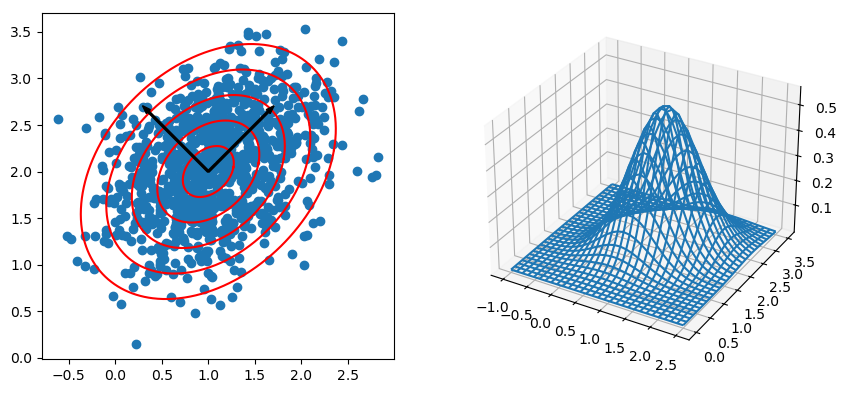

In [1]:
import numpy as np
import matplotlib.pyplot as plt


mean = np.array([1,2])
sigma = np.array([[0.3,0.1],[0.1,0.3]])
sigma_eigenvalues = np.linalg.eig(sigma)[0]
sigma_eigenvectors = np.linalg.eig(sigma)[1]

# The eigenvectors of the symmetrix matrix sigma are orthogonal.  We can write sigma = VDV^top.  
# The unique positive square root of sigma is VD^{1/2}V^top

sigma_sqrt = np.dot(sigma_eigenvectors, np.dot(np.sqrt(np.diag(sigma_eigenvalues)), np.transpose(sigma_eigenvectors)))

# X is a (1000,2) array.  Each row has been randomly chosen following a multivariate normal distribution with 
# mean [1,2] and with covariance matrix [[0.3,0.1],[0.1,0.3]]

X = np.random.multivariate_normal(mean , sigma, size = 1000)

fig = plt.figure(figsize=(10,5))
ax1 = fig.add_subplot(1, 2, 1)
ax1.set_aspect('equal', adjustable='box')

ax1.scatter(X[:,0],X[:,1])

t = np.linspace(0, 2*3.14, 1000)

# The y all lie on a circle.
y = np.array([np.cos(t), np.sin(t)])

for i in [0.5,1,1.5,2, 2.5]:
    x = mean + i*np.dot(np.transpose(y), sigma_sqrt)
    ax1.plot(x[:,0],x[:,1], color = 'red')

# These arrows are the eigenvectors of sigma, shifted so that the tail is located at the mean. 
ax1.arrow(1, 2, sigma_eigenvectors[0,0], sigma_eigenvectors[1,0], width = 0.02, color = 'black', length_includes_head = True, zorder = 3)
ax1.arrow(1, 2, sigma_eigenvectors[0,1], sigma_eigenvectors[1,1], width = 0.02, color = 'black', length_includes_head = True, zorder = 3)


#Following code from https://stackoverflow.com/a/40623343

from mpl_toolkits.mplot3d import Axes3D
from scipy.stats import multivariate_normal

x, y = np.mgrid[-1.0:2.5:30j, 0:3.5:30j]

# Need an (N, 2) array of (x, y) pairs.
xy = np.column_stack([x.flat, y.flat])


z = multivariate_normal.pdf(xy, mean=mean, cov=sigma)

# Reshape back to a (30, 30) grid.
z = z.reshape(x.shape)


ax2 = fig.add_subplot(122, projection='3d')

ax2.plot_wireframe(x,y,z)

plt.show()

We can also use this change of variables to show that the pdf does integrate to $1$:

$$
\begin{align}
\int_{\mathbb{R}^p} \frac{1}{\sqrt{(2\pi)^{p}|\Sigma|}} \operatorname{exp}\left( -\frac{1}{2}(\vec{x} - \vec{\mu})^\top \Sigma^{-1} (\vec{x} - \vec{\mu}) \right) \textrm{d} \vec{x}
&= \int_{\mathbb{R}^p} \frac{1}{\sqrt{(2\pi)^{p}}} \operatorname{exp}\left( -\frac{1}{2} |\vec{y}|^2 \right) \textrm{d} \vec{y} \\
&= \frac{1}{\sqrt{(2\pi)^{p}}} \prod_{i=1}^{i=p} \int_{-\infty}^{\infty} \operatorname{exp}\left( -\frac{1}{2} y_i^2 \right) \textrm{d} y_i\\
&= 1 
\end{align}
$$

Where we have used

1. The multivariable change of variables formula (the Jacobian of the transformation is $|\Sigma^{\frac{1}{2}}|$)
2. Fubini's theorem, together with the decomposition of $|\vec{y}|^2 = y_1^2 + y_2^2 + ... + y_p^2$.
3. The integral of the univariate Gaussian.

We can calculate that the expected value really is $\vec{\mu}$:

$$
\begin{align*}
\mathbb{E}(\vec{x}) 
&= \int_{\mathbb{R}^p} \vec{x}P(\vec{x}) \textrm{d} \vec{x}\\
&= \frac{1}{\sqrt{(2\pi)^{p}}} \int_{\mathbb{R}^p} (\vec{\mu} + \Sigma^{\frac{1}{2}}\vec{y})  \operatorname{exp}\left( -\frac{1}{2} |\vec{y}|^2 \right) \textrm{d} \vec{y}\\
&= \vec{\mu} + \frac{1}{\sqrt{(2\pi)^{p}}}\Sigma^{\frac{1}{2}} \int_{\mathbb{R}^p} \vec{y} \operatorname{exp}\left( -\frac{1}{2} |\vec{y}|^2 \right) \textrm{d} \vec{y}\\
&= \vec{\mu}
\end{align*}
$$

where the final integrand vanishes due to symmetry of the integrand (exchanging $\vec{y}$ with $-\vec{y}$ changes the sign of the integrand).

We can also calculate that the covariance matrix really is $\Sigma$:



We have seen that the entries of $\vec{y}$ are independent standard normal variables, so $\operatorname{Cov}(\vec{y}) = I$.

So

$$
\begin{align*}
\operatorname{Cov}(\vec{x}) 
&= \mathbb{E}((\vec{x} - \vec{\mu})(\vec{x} - \vec{\mu})^\top)\\
&= \mathbb{E}((\Sigma^{\frac{1}{2}} \vec{y})(\Sigma^{\frac{1}{2}} \vec{y})^\top)\\ 
&= \Sigma^{\frac{1}{2}}  \mathbb{E}(\vec{y} \vec{y}^\top)\Sigma^{\frac{1}{2}} \\ 
&= \Sigma^{\frac{1}{2}} I \Sigma^{\frac{1}{2}} \\ 
&= \Sigma
\end{align*}
$$


## Linear and Quadratic Discriminant Analysis

In **Linear Discriminant Analysis** (LDA) we have $p$ continuous features $\vec{x}$ and a single categorical variable ($y = 1, 2, \dots, k$).  We will assume that the conditional probabilites $P(\vec{x} | y = j)$ are multivariate normal distributions with **the same** covariance matrix $\Sigma$ but different means $\vec{\mu}_j$.  This is a pretty strong assumption about the data, so you should be cautious. In **Quadratic Discriminant Analysis** (QDA) we drop the assumption that the covariance matrices are the same.

In either case we use Bayes' theorem to determine the probability of $y = j$ given $\vec{x}$:

$$
\begin{align*}
P(y = j | \vec{x}) 
&= \frac{P(\vec{x} | y = j)P(y = j)}{P(\vec{x})}\\
&= \frac{P(\vec{x} | y =j)P(y = j)}{\displaystyle\sum_i P(\vec{x}| y = i) P(y = i)}
\end{align*}
$$

$\pi_i = P(y = i)$  can be estimated from the data by just taking the fraction of samples in each class.  We will find the conditional probabilities using a maximum likelihood estimation of the parameters $\vec{\mu}_j$ and $\Sigma$.

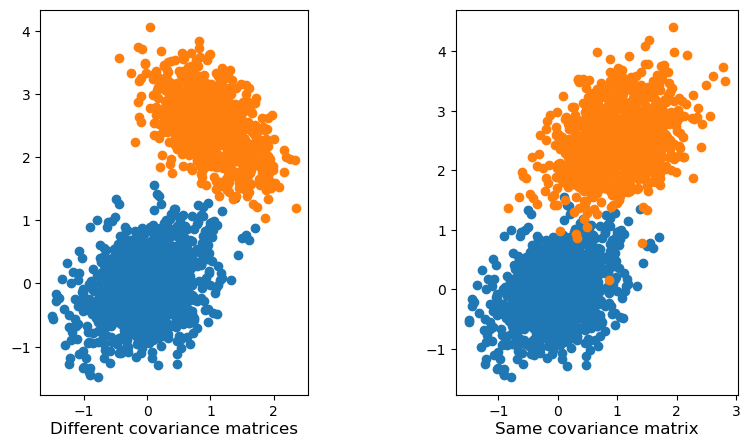

In [2]:
mean1 = np.array([0,0])
sigma1 = np.array([[0.3,0.1],[0.1,0.3]])
X1 = np.random.multivariate_normal(mean1 , sigma1, size = 1000)

mean2 = np.array([1,2.5])
sigma2 = np.array([[0.2,-0.1],[-0.1,0.2]])
X2 = np.random.multivariate_normal(mean2 , sigma2, size = 1000)

fig = plt.figure(figsize=(10,5))
ax1 = fig.add_subplot(1, 2, 1)
ax1.set_aspect('equal')

ax1.scatter(X1[:,0],X1[:,1])
ax1.scatter(X2[:,0],X2[:,1])

ax2 = fig.add_subplot(1, 2, 2)
ax2.set_aspect('equal')

X2 = np.random.multivariate_normal(mean2 , sigma1, size = 1000)
ax2.scatter(X1[:,0],X1[:,1])
ax2.scatter(X2[:,0],X2[:,1])

ax1.text(0.5,-0.1, "Different covariance matrices", size=12, ha="center", 
         transform=ax1.transAxes)
ax2.text(0.5,-0.1, "Same covariance matrix", size=12, ha="center", 
         transform=ax2.transAxes)

plt.show()

In the next section we will see how to obtain maximum likelihood estimates for $\vec{\mu}_j$ and $\Sigma$ from a dataset.  For now, let's assume that we already have these estimates.

Linear discriminant analysis leads to linear decision boundaries:

$$
\begin{align*}
& P(y = j | \vec{x}) = P(y = i| \vec{x})\\
& \frac{P(\vec{x} | y = j)P(y = j)}{P(\vec{x})} = \frac{P(\vec{x} | y = i)P(y = i)}{P(\vec{x})}\\
& \frac{P(\vec{x} | y = j)}{P(\vec{x} | y = i)} = \frac{\pi_i}{\pi_j}\\
& \frac{\operatorname{exp}\left( -\frac{1}{2}(\vec{x} - \vec{\mu_j})^\top \Sigma^{-1} (\vec{x} - \vec{\mu_j}) \right) }{\operatorname{exp}\left( -\frac{1}{2}(\vec{x} - \vec{\mu_i})^\top \Sigma^{-1} (\vec{x} - \vec{\mu_i}) \right) } = \frac{\pi_i}{\pi_j}\\
& (\vec{x} - \vec{\mu_j})^\top \Sigma^{-1} (\vec{x} - \vec{\mu_j}) - (\vec{x} - \vec{\mu_i})^\top \Sigma^{-1} (\vec{x} - \vec{\mu_i})  = 2\log(\frac{\pi_j}{\pi_i})\\ 
\end{align*}
$$

Note that since $\Sigma^{-1}$ is symmetric we have (for any $\vec{\mu}$)

$$
(\vec{x} - \vec{\mu})^\top \Sigma^{-1} (\vec{x} - \vec{\mu}) = \vec{x}^\top \Sigma^{-1} \vec{x} - 2\vec{x}^\top \Sigma^{-1} \vec{\mu} + \vec{\mu}^\top \Sigma^{-1} \vec{\mu}
$$

Expanding both expressions in this way the quadratic $\vec{x}^\top \Sigma^{-1} \vec{x}$ terms cancel and we have

$$
\begin{align*}
&-2\vec{x}^\top \Sigma^{-1} (\vec{\mu}_j - \vec{\mu}_i) + \vec{\mu}_j^\top \Sigma^{-1} \vec{\mu}_j - \vec{\mu}_i^\top \Sigma^{-1} \vec{\mu}_i = 2\log(\frac{\pi_j}{\pi_i})\\ 
&\vec{x}^\top \Sigma^{-1} (\vec{\mu}_j - \vec{\mu}_i) = \frac{1}{2}(\vec{\mu}_j + \vec{\mu}_i)^\top \Sigma^{-1} (\vec{\mu}_j - \vec{\mu}_i) - \log(\frac{\pi_j}{\pi_i})
\end{align*}
$$


We can see that the decision boundary is a hyperplane!  So LDA will partition $\mathbb{R}^p$ into $k$ subregions bounded by such hyperplanes.

In QDA we would obtain

$$
(\vec{x} - \vec{\mu_j})^\top \Sigma_j^{-1} (\vec{x} - \vec{\mu_j}) - (\vec{x} - \vec{\mu_i})^\top \Sigma_i^{-1} (\vec{x} - \vec{\mu_i})  = 2\log(\frac{\pi_j}{\pi_i})
$$

We are no longer able to cancel the $\vec{x}^\top \Sigma \vec{x}$ terms, so this is a quadratic equation in $p$ variables.  In general the decision boundary will be a quadratic surface.  Note that we end up with a $\vec{x}^\top (\Sigma_j - \Sigma_i) \vec{x}$ term, and $(\Sigma_j - \Sigma_i)$ is symmetric but doesn't have to be positive definite.

I think it is worth trying to understand the LDA decision boundary formula geometrically in the case that the two classes occur with equal probability (so that the log term vanishes).  Then we have a decision boundary of 

$$
\begin{align*}
&\vec{x}^\top \Sigma^{-1} (\vec{\mu}_j - \vec{\mu}_i) = \frac{1}{2}(\vec{\mu}_j + \vec{\mu}_i)^\top \Sigma^{-1} (\vec{\mu}_j - \vec{\mu}_i)\\
&\left \langle \vec{x} - \frac{\vec{\mu}_j + \vec{\mu}_i}{2}, \Sigma^{-1} (\vec{\mu}_j - \vec{\mu}_i) \right \rangle  = 0\\
&\left\langle  \Sigma^{-\frac{1}{2}} \left(\vec{x} - \frac{\vec{\mu}_j + \vec{\mu}_i}{2}\right), \Sigma^{-\frac{1}{2}} \left(\vec{\mu}_j - \vec{\mu}_i\right) \right\rangle  = 0
\end{align*}
$$

This just says that the sphered decision boundary is the perpendicular bisector of the sphered difference of means!

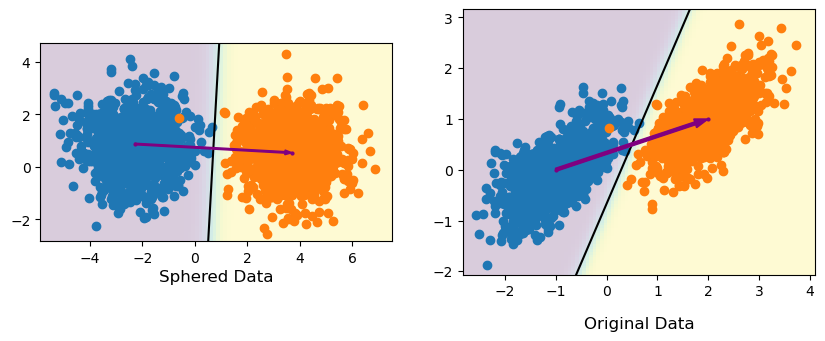

In [3]:
mean1 = np.array([-1,0])
mean2 = np.array([2,1])
sigma = np.array([[0.3,0.2],[0.2,0.3]])

# Finding the square root and inverse square root of sigma.
sigma_eigenvalues = np.linalg.eig(sigma)[0]
sigma_eigenvectors = np.linalg.eig(sigma)[1]
sigma_sqrt = np.dot(sigma_eigenvectors, np.dot(np.sqrt(np.diag(sigma_eigenvalues)), np.transpose(sigma_eigenvectors)))
sigma_sqrt_inv = np.linalg.inv(sigma_sqrt)

# Generating data
X1 = np.random.multivariate_normal(mean1 , sigma, size = 1000)
X2 = np.random.multivariate_normal(mean2 , sigma, size = 1000)

# Finding midpoint between means and difference between means
mid = (mean1 + mean2)/2
diff = mean2 - mean1

# Finding the preimages of all data under mapping p -> sigma_sqrt(p)
mean1_pre = np.dot(sigma_sqrt_inv, mean1.reshape(-1,1))
mean2_pre = np.dot(sigma_sqrt_inv, mean2.reshape(-1,1))
mid_pre = (mean1_pre + mean2_pre)/2
diff_pre = mean2_pre - mean1_pre
X1_pre = np.dot(X1, np.transpose(sigma_sqrt_inv) )
X2_pre = np.dot(X2, np.transpose(sigma_sqrt_inv) )


fig = plt.figure(figsize=(10,5))

# Plotting sphered data
ax1 = fig.add_subplot(1, 2, 1)
ax1.set_aspect('equal')
ax1.scatter(X1_pre[:,0],X1_pre[:,1])
ax1.scatter(X2_pre[:,0],X2_pre[:,1])
ax1.scatter( mean1_pre[0,0], mean1_pre[1,0], color = 'purple', s = 4)
ax1.scatter( mean2_pre[0,0], mean2_pre[1,0], color = 'purple', s = 4)
ax1.arrow(mean1_pre[0,0], mean1_pre[1,0], diff_pre[0,0], diff_pre[1,0], width = 0.06, color = 'purple', length_includes_head = True, zorder = 3)

x_pre_min = np.min(np.concatenate([X1_pre,X2_pre], axis = 0), axis = 0)[0]*1.1
y_pre_min = np.min(np.concatenate([X1_pre,X2_pre], axis = 0), axis = 0)[1]*1.1
x_pre_max = np.max(np.concatenate([X1_pre,X2_pre], axis = 0), axis = 0)[0]*1.1
y_pre_max = np.max(np.concatenate([X1_pre,X2_pre], axis = 0), axis = 0)[1]*1.1

ax1.set_xlim([x_pre_min,x_pre_max])
ax1.set_ylim([y_pre_min,y_pre_max])

x = np.linspace(x_pre_min,x_pre_max,100)

# This is the explicit formula for perpendicular bisector of the line segment joining the sphered means.
y = (-diff_pre[0,0]/diff_pre[1,0])*(x - mid_pre[0,0]) + mid_pre[1,0]
ax1.plot(x,y, color = 'black')

# storing the points on this line for later, since I will need to transform them.
line_points_pre =  np.stack([x,y], axis = 1)

# Graphing the classes determined by sklearns implementation of LDA to make sure we are not too far off the mark.
# Code borrowed from https://scikit-learn.org/stable/auto_examples/classification/plot_lda_qda.html#sphx-glr-auto-examples-classification-plot-lda-qda-py

from  sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
clf = LDA()
clf.fit(np.concatenate([X1_pre,X2_pre], axis = 0), np.concatenate([np.zeros((1000)),np.ones((1000))],axis = 0))

xx, yy = np.meshgrid(np.linspace(x_pre_min, x_pre_max, 100), np.linspace(y_pre_min, y_pre_max, 100))
Z = clf.predict_proba(np.c_[xx.ravel(), yy.ravel()])
Z = Z[:, 1].reshape(xx.shape)
ax1.pcolormesh(xx, yy, Z, zorder=0, alpha = 0.2)

# Plotting original data on second set of axes
ax2 = fig.add_subplot(1, 2, 2)
ax2.set_aspect('equal')

ax2.scatter(X1[:,0],X1[:,1])
ax2.scatter(X2[:,0],X2[:,1])
ax2.scatter( mean1[0], mean1[1], color = 'purple', s = 4)
ax2.scatter( mean2[0], mean2[1], color = 'purple', s = 4)
ax2.arrow(mean1[0], mean1[1], diff[0], diff[1], width = 0.06, color = 'purple', length_includes_head = True, zorder = 3)

x_min = np.min(np.concatenate([X1,X2], axis = 0), axis = 0)[0]*1.1
y_min = np.min(np.concatenate([X1,X2], axis = 0), axis = 0)[1]*1.1
x_max = np.max(np.concatenate([X1,X2], axis = 0), axis = 0)[0]*1.1
y_max = np.max(np.concatenate([X1,X2], axis = 0), axis = 0)[1]*1.1

ax2.set_xlim([x_min,x_max])
ax2.set_ylim([y_min,y_max])

# We get the points on the decision boundary by transforming the points on the sphered decision boundary
line_points = np.dot(line_points_pre, np.transpose(sigma_sqrt))

ax2.plot(line_points[:,0], line_points[:,1], color = 'black')

# Graphing the classes determined by sklearns implementation of LDA to make sure we are not too far off the mark.
clf.fit(np.concatenate([X1,X2], axis = 0), np.concatenate([np.zeros((1000)),np.ones((1000))],axis = 0))

xx, yy = np.meshgrid(np.linspace(x_min, x_max, 100), np.linspace(y_min, y_max, 100))
Z = clf.predict_proba(np.c_[xx.ravel(), yy.ravel()])
Z = Z[:, 1].reshape(xx.shape)

ax2.pcolormesh(xx, yy, Z, zorder=0, alpha = 0.2)

ax1.text(0.5,-0.2, "Sphered Data", size=12, ha="center", 
         transform=ax1.transAxes)
ax2.text(0.5,-0.2, "Original Data", size=12, ha="center", 
         transform=ax2.transAxes)

plt.show()

Below we show what decision boundaries look like in the multiclass case.  These are Voronoi diagrams using the [Mahalanobis distance](https://en.wikipedia.org/wiki/Mahalanobis_distance)!

/var/folders/14/6_njfgsd63b_nr13v4mq3fb00000gn/T/ipykernel_95286/1657203057.py:8: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  viridis = cm.get_cmap('viridis', 5)


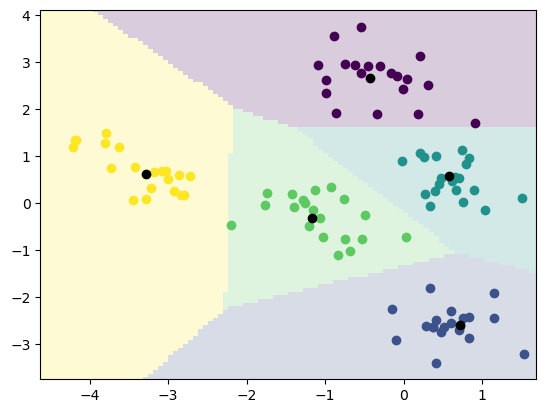

In [8]:
means = np.random.multivariate_normal(np.array([0,0]) , np.array([[3,1],[1,3]]), size = 5)

import matplotlib.cm as cm

fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)

viridis = cm.get_cmap('viridis', 5)

Xs = np.zeros((100,2))
ys = np.zeros(100)
for i in range(5):
    X = np.random.multivariate_normal(means[i,:], np.array([[0.2,-0.1],[-0.1,0.2]]), size = 20)
    y= np.ones(20)*i
    Xs[20*i:20*i+20,:] = X
    ys[20*i:20*i+20] = y
    plt.scatter(X[:,0],X[:,1], color = viridis(i))

plt.scatter(means[:,0], means[:,1], color = "black")

clf.fit(Xs, ys)

x_min = np.min(Xs, axis = 0)[0]*1.1
y_min = np.min(Xs, axis = 0)[1]*1.1
x_max = np.max(Xs, axis = 0)[0]*1.1
y_max = np.max(Xs, axis = 0)[1]*1.1

ax.set_xlim([x_min,x_max])
ax.set_ylim([y_min,y_max])

xx, yy = np.meshgrid(np.linspace(x_min, x_max, 100), np.linspace(y_min, y_max, 100))
Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])*25

plt.pcolormesh(xx, yy, Z.reshape((100,100)), zorder=0, alpha = 0.2)

plt.show()


Here are 2 examples of QDA decision boundaries:

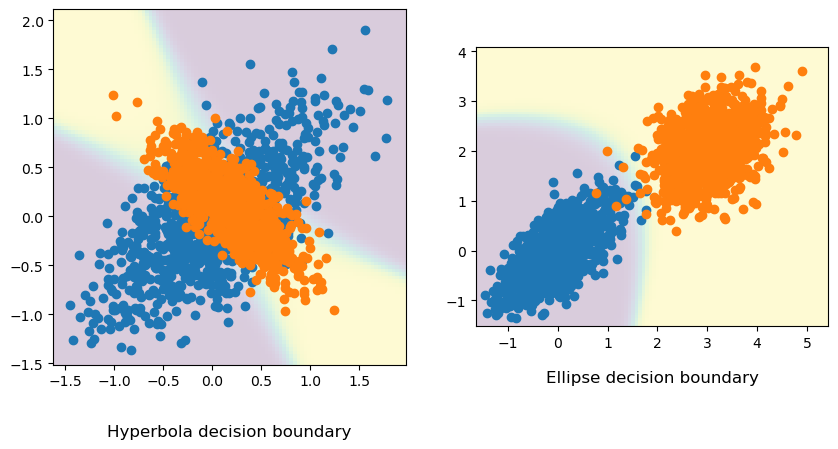

In [5]:
mean1 = np.array([0,0])
mean2 = np.array([0.2,0.1])
mean3 = np.array([3,2])
sigma1 = np.array([[0.3,0.2],[0.2,0.3]])
sigma2 = np.array([[0.13,-0.1],[-0.1,0.13]])
sigma3 = np.array([[0.3,0.1],[0.1,0.3]])

X1 = np.random.multivariate_normal(mean1 , sigma1, size = 1000)
X2 = np.random.multivariate_normal(mean2 , sigma2, size = 1000)
X3 = np.random.multivariate_normal(mean3 , sigma3, size = 1000)

fig = plt.figure(figsize=(10,5))
ax1 = fig.add_subplot(1, 2, 1)
ax1.set_aspect('equal')
ax1.scatter(X1[:,0],X1[:,1])
ax1.scatter(X2[:,0],X2[:,1])

x_min = np.min(np.concatenate([X1,X2], axis = 0), axis = 0)[0]*1.1
y_min = np.min(np.concatenate([X1,X2], axis = 0), axis = 0)[1]*1.1
x_max = np.max(np.concatenate([X1,X2], axis = 0), axis = 0)[0]*1.1
y_max = np.max(np.concatenate([X1,X2], axis = 0), axis = 0)[1]*1.1

from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis as QDA
clf = QDA()
clf.fit(np.concatenate([X1,X2], axis = 0), np.concatenate([np.zeros((1000)),np.ones((1000))],axis = 0))

xx, yy = np.meshgrid(np.linspace(x_min, x_max, 100), np.linspace(y_min, y_max, 100))
Z = clf.predict_proba(np.c_[xx.ravel(), yy.ravel()])
Z = Z[:, 1].reshape(xx.shape)

ax1.pcolormesh(xx, yy, Z, zorder=0, alpha = 0.2)

ax2 = fig.add_subplot(1, 2, 2)
ax2.set_aspect('equal')
ax2.scatter(X1[:,0],X1[:,1])
ax2.scatter(X3[:,0],X3[:,1])

x_min = np.min(np.concatenate([X1,X3], axis = 0), axis = 0)[0]*1.1
y_min = np.min(np.concatenate([X1,X3], axis = 0), axis = 0)[1]*1.1
x_max = np.max(np.concatenate([X1,X3], axis = 0), axis = 0)[0]*1.1
y_max = np.max(np.concatenate([X1,X3], axis = 0), axis = 0)[1]*1.1

clf.fit(np.concatenate([X1,X3], axis = 0), np.concatenate([np.zeros((1000)),np.ones((1000))],axis = 0))

xx, yy = np.meshgrid(np.linspace(x_min, x_max, 100), np.linspace(y_min, y_max, 100))
Z = clf.predict_proba(np.c_[xx.ravel(), yy.ravel()])
Z = Z[:, 1].reshape(xx.shape)

ax2.pcolormesh(xx, yy, Z, zorder=0, alpha = 0.2)

ax1.text(0.5,-0.2, "Hyperbola decision boundary", size=12, ha="center", 
         transform=ax1.transAxes)
ax2.text(0.5,-0.2, "Ellipse decision boundary", size=12, ha="center", 
         transform=ax2.transAxes)

plt.show()




## MLE for $\vec{\mu}_j$ and $\Sigma$ for binary LDA.

We are going to restrict ourselves to the binary case when computing maximum likelihood estimates of the parameters for LDA (it gets hairy enough as it is for two classes).

We are given an $n_j \times p$ design matrix $X_j$ for observations of class $y = j$ (with $j = 0$ or $1$).  We will also use $n = n_0+ n_1$, $X$ as the $n \times p$ design matrix stacking the $X_j$, and $\vec{y}$ for the $n$ vector of observed classes.

We want to choose $\vec{\mu}_j$ and $\Sigma$ so that the probability of having observed $(X, \vec{y})$ is maximized.

As is often the case, rather than maximizing this quantity we minimize the negative log likelyhood.

In what follows you should interpret $P(X)$ as the $n$ vector obtained by applying $P$ to each row of $X$.

$$
\begin{align*}
\ell(\vec{\mu}_0, \vec{\mu}_1, \Sigma) 
&= - (1 - \vec{y}) \cdot \log(P_{\vec{\mu}_0, \Sigma}(X)) - \vec{y} \cdot \log(P_{\vec{\mu}_1, \Sigma}(X))\\
\end{align*}
$$

First we find the derivative of $\ell$ with respect to $\vec{\mu}_0$.  Let $\vec{x}_j$ be the $j^{th}$ row of $X_0$, and let $\bar{x}_0$ denote the mean of all $n_0$ samples for the following computation.

$$
\begin{align}
\frac{\partial \ell}{\partial \vec{\mu}_0} 
&=  - \frac{\partial}{\partial \vec{\mu}_0} \sum_{j=0}^{n_0} \log(P_{\vec{\mu}_0, \Sigma}(\vec{x}_j))\\
&= - \frac{\partial}{\partial \vec{\mu}_0} \sum_{j=0}^{n_0} \log\left( \frac{1}{\sqrt{(2\pi)^{p}|\Sigma|}} \operatorname{exp}\left( -\frac{1}{2}(\vec{x}_j - \vec{\mu_0})^\top \Sigma^{-1} (\vec{x}_j - \vec{\mu_0}) \right) \right)\\
&= \frac{1}{2} \sum_{j=0}^{n_0} \frac{\partial}{\partial \vec{\mu}_0} (\vec{x}_j - \vec{\mu}_0)^\top \Sigma^{-1} (\vec{x}_j - \vec{\mu}_0)\\
&= \sum_{j=0}^{n_1} \Sigma^{-1}(\vec{\mu}_0 - \vec{x}_j)\\
&= n_0 \Sigma^{-1}(\vec{\mu}_0 - \bar{x}_0)
\end{align}
$$

So we obtain the estimate

$$
\vec{\mu}_0 = \bar{x}_0
$$

Similarly we must have

$$
\vec{\mu}_1 = \bar{x}_1
$$

These are not surprizing:  we are saying that the MLE estimate of the mean vectors are just the sample mean vectors.  The estimation of the covariance $\Sigma$ is a bit trickier.


First note that for a given $\vec{x}$ and $\mu$ we have 

$$
\begin{align*}
&P_{\vec{\mu}, \Sigma}(\vec{x}) = \frac{1}{\sqrt{(2\pi)^{p}|\Sigma|}} \operatorname{exp}\left( -\frac{1}{2}(\vec{x} - \vec{\mu})^\top \Sigma^{-1} (\vec{x} - \vec{\mu}) \right)\\
&\log(P_{\vec{\mu}, \Sigma}(\vec{x})) = -\frac{p}{2}\log(2\pi) + \frac{1}{2}\log(|\Sigma^{-1}|) -\frac{1}{2}(\vec{x} - \vec{\mu})^\top \Sigma^{-1} (\vec{x} - \vec{\mu})
\end{align*}
$$

We have the following identities (which can be found on [wikipedia](https://en.wikipedia.org/wiki/Matrix_calculus#Scalar-by-matrix_identities)):

$$
\frac{\partial}{\partial \Sigma^{-1}} \log(|\Sigma^{-1}|) = \Sigma
$$

and

$$
\frac{\partial}{\partial \Sigma^{-1}} (\vec{x} - \vec{\mu})^\top \Sigma^{-1} (\vec{x} - \vec{\mu}) = (\vec{x} - \vec{\mu})(\vec{x} - \vec{\mu})^\top
$$

So overall we have

$$
\frac{\partial }{\partial \Sigma^{-1}} \log(P_{\vec{\mu}, \Sigma}(\vec{x})) = \frac{1}{2} \Sigma - \frac{1}{2}(\vec{x} - \vec{\mu})(\vec{x} - \vec{\mu})^\top
$$

Note:  What we mean by the derivative of a scalar valued function $f$ of a matrix $X$ is that

$$
\frac{\partial f}{\partial X} = \begin{bmatrix} \frac{\partial f}{\partial X_{i,j}}\end{bmatrix}
$$



Let $\vec{x}_j^0$ and $\vec{x}_j^1$ denote the $j^{th}$ sample from $X_0$ and $X_1$ respectively.  Then

$$
\ell(\vec{\mu}_0, \vec{\mu}_1, \Sigma) 
=  \sum_{1}^{n_0} \log(P_{\vec{\mu_0}, \Sigma}(\vec{x}_j^0)) + \sum_{1}^{n_1} \log(P_{\vec{\mu_1}, \Sigma}(\vec{x}_j^1))\\
$$

so 

$$
\begin{align*}
\frac{\partial \ell}{\partial \Sigma} 
&=  \sum_{1}^{n_0} \left( \frac{1}{2} \Sigma - \frac{1}{2}(\vec{x}_j^0 - \vec{\mu_0})(\vec{x}_j^0 - \vec{\mu_0})^\top \right) + 
\sum_{1}^{n_1} \left( \frac{1}{2} \Sigma - \frac{1}{2}(\vec{x}_j^1 - \vec{\mu_1})(\vec{x}_j^1 - \vec{\mu_1})^\top \right)\\
&= \frac{n_1 + n_2}{2}\Sigma - \frac{1}{2} \left( \sum_{1}^{n_0} (\vec{x}_j^0 - \vec{\mu_0})(\vec{x}_j^0 - \vec{\mu_0})^\top +  \sum_{1}^{n_1} (\vec{x}_j^1 - \vec{\mu_1})(\vec{x}_j^1 - \vec{\mu_1})^\top\right)
\end{align*}
$$

Setting this equal to zero, we obtain the MLE

$$
\Sigma = \frac{1}{n_0 + n_1} \left( \sum_{1}^{n_0} (\vec{x}_j^0 - \vec{\mu_0})(\vec{x}_j^0 - \vec{\mu_0})^\top +  \sum_{1}^{n_1} (\vec{x}_j^1 - \vec{\mu_1})(\vec{x}_j^1 - \vec{\mu_1})^\top\right)
$$

Let's test that we obtain the same covariance matrix using this formulas as we do using sklearn.

In [6]:
# example lifted from https://scikit-learn.org/stable/modules/generated/sklearn.discriminant_analysis.LinearDiscriminantAnalysis.html

X = np.array([[-1, -1], [-2, -1], [-3, -2], [1, 1], [2, 1], [3, 2]])
y = np.array([0, 0, 0, 1, 1, 1])
clf = LDA(store_covariance=True)
clf.fit(X, y)
print('sklearn covariance = \n', clf.covariance_)

X_0 = X[:3,:]
X_1 = X[3:,:]
mu_0 = np.mean(X_0, axis = 0)
mu_1 = np.mean(X_1, axis = 0)

X_0 = X_0 - np.tile(mu_0, (3,1))
X_1 = X_1 - np.tile(mu_1, (3,1))

our_covariance = (1/y.shape[0])*(np.dot(np.transpose(X_0), X_0 ) + np.dot(np.transpose(X_1), X_1 ))
print('our computed covariance = \n',our_covariance)
print('They are the same!')

sklearn covariance = 
 [[0.66666667 0.33333333]
 [0.33333333 0.22222222]]
our computed covariance = 
 [[0.66666667 0.33333333]
 [0.33333333 0.22222222]]
They are the same!


Note:  The MLE for QDA is actually easier, since each covariance matrix can be estimated independently!  We end up just getting the sample covariance for each class, as expected.